# Bank Churn Analysis

In [1]:
# import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# data splitting
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# binning
from sklearn.preprocessing import KBinsDiscretizer

# polynomial features
from sklearn.preprocessing import PolynomialFeatures

# features importances
from statsmodels.stats.outliers_influence import variance_inflation_factor

# column transfornmer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

# imbalanced
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# cross validation
from sklearn.model_selection import cross_val_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# modeling
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# modeling -> ensemble various type
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ensemble similar type
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier   

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# supress warning
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **1. Business Understanding and Problem Framing**

Dataset ini merupakan dataset nasabah dari suatu bank. Tujuan utama dari analisis dataset ini adalah untuk memprediksi nasabah/customer bank yang berpotensi untuk melakukan churn. Dengan melakukkan prediksi ini, bank dapat melakukan intervensi preventif untuk mempertahankan customer tersebut.

**Prediksi Customer Bank yang Churn/Not Churn**

Target column: `Exited`
- 0 --> Not churn
- 1 --> Churn

**Metrics Evaluation:**

- 🔴 False Negative (FN): Model memprediksi `Tidak Churn` padahal aslinya `Churn`. 
    - Bannk gagal medeteksi customer yang berisiko pergi.
    - Tidak ada strategi untuk retensi yang dilakukan.
    - Implikasi bisnisnya adalah potensi kerugian bank karena akan kehilangan customer tanpa ada pencegahan sehingga ada potensi kehilangan pendapatan.
- 🔵 False Positive (FP): Model memprediksi `Churn` padahal aslinya `Tidak Churn`. 
    - Bank salah sasaran dalam menawarkan program retensi (diskon, bonus, layanan tambahan).
    - Biaya operasional sia-sia karena diberikan kepada customer yang sebenarnya tidak akan pergi.
    - Implikasi bisnisnya adalah bank akan merugi secara finansial akibat memberikan fasilitas dan layanan kepada customer yang ternyata tidak memerlukan layanan tersebut.

- ⚖️ Pemilihan Metrics Evaluation: 
    - Kedua jenis kesalahan FN & FP sama-sama merugikan
    - Precision & Recall:
        + Precision penting untuk meminimalkan FP (tidak buang-buang insentif).
        + Recall penting untuk meminimalkan FN (tidak kehilangan nasabah).
    - F1 Score menjadi metrik yang tepat karena menyeimbangkan antara Precision dan Recall.

## **2. Data Understanding**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Deksripsi Kolom**

| Nama Kolom       | Deskripsi                                               |
|------------------|---------------------------------------------------------|
| Surname          | Nama belakang                                           |
| CreditScore      | Skor kredit                                             |
| Geography        | Negara (Germany / France / Spain)                    |
| Gender           | Jenis kelamin (Female / Male)                  |
| Age              | Usia                                                    |
| Tenure           | Lama menjadi nasabah (dalam tahun)                      |
| Balance          | Saldo rekening                                          |
| NumOfProducts    | Jumlah produk perbankan yang digunakan                  |
| HasCrCard        | Status kepemilikan kartu kredit (0 = Tidak, 1 = Ya)     |
| IsActiveMember   | Status keanggotaan aktif (0 = Tidak, 1 = Ya)            |
| EstimatedSalary  | Perkiraan gaji                                          |
| Exited           | Apakah berhenti menjadi nasabah? (0 = Tidak, 1 = Ya)    |

## **3. Data Cleansing**

In [5]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [3]:
df['Geography'] = df['Geography'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  object  
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  int64   
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(9), object(1)
memory usage: 957.4+ KB


## **4. EDA**

In [4]:
# proporsi data target
df['Exited'].value_counts(normalize= True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Data target `Exited` termasuk dalam data imbalance karena data `0` = 79% dan data `1` = 20% yang berarti terdapat gap yang jauh.

In [10]:
# Cek nilai unik untuk tiap kolom kategorikal, kecuali CustomerID
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.drop(['CustomerId','RowNumber','Surname'], errors='ignore')

for col in categorical_columns:
    print(f"Kolom: {col}")
    print(df[col].value_counts(dropna=False))
    print("="*40)

Kolom: Geography
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
Kolom: Gender
Gender
Male      5457
Female    4543
Name: count, dtype: int64


=== Ringkasan Statistik ===
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797 

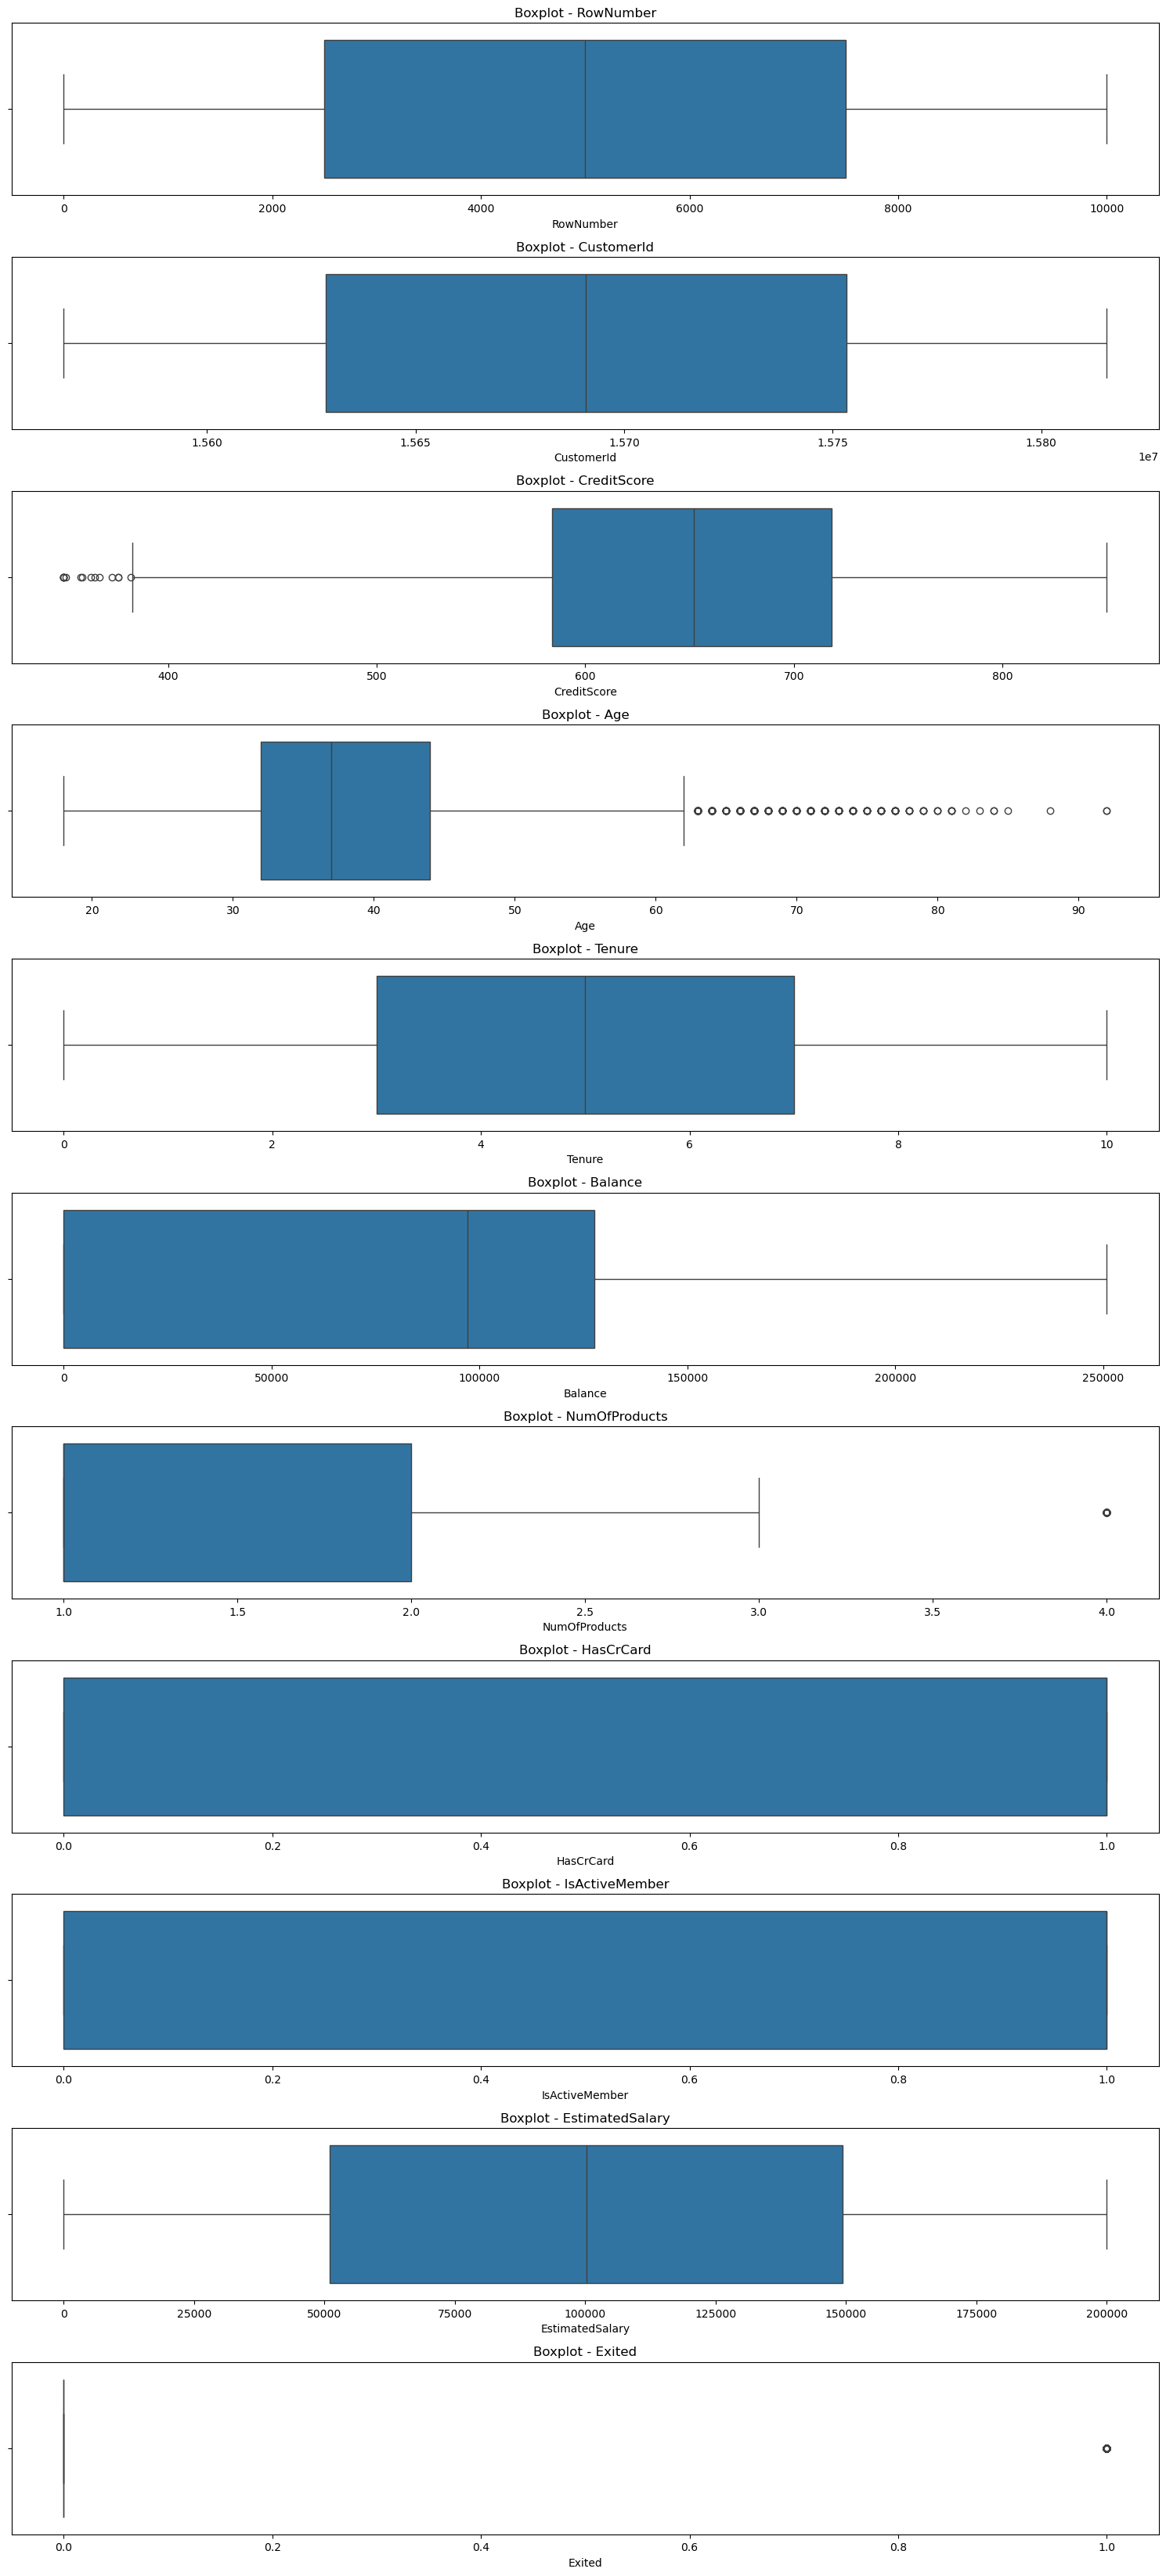

In [11]:
# Identifikasi kolom numerikal
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Descriptive statistics
print("=== Ringkasan Statistik ===")
print(df[numerical_columns].describe())
print("\n")

# Boxplots untuk semua kolom numerik
plt.figure(figsize=(15, len(numerical_columns) * 3))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

<Axes: >

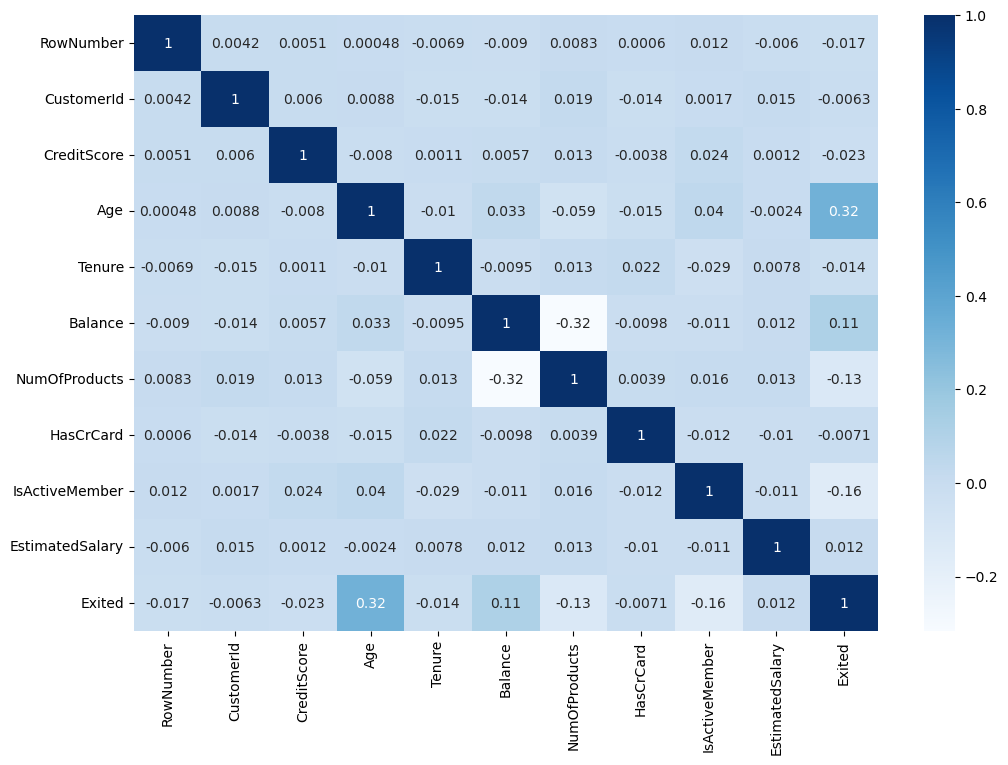

In [12]:
# Identifikasi kolom numerikal
numerical_columns = df.select_dtypes(include=['int64', 'float64'])

df_Corr = numerical_columns.corr(method = 'spearman')
plt.figure(figsize = (12,8))
sns.heatmap(df_Corr, annot = True, cmap = 'Blues')

Yang berkorelasi kuat ada `Age`, `EstimatedSalary`, dan `Balance`

## **5. Data Preprocessing**

### define X dan y

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
X = df.drop(columns= ['RowNumber', 'CustomerId', 'Surname', 'Exited'])

y = df['Exited']

### train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                 y,
                 random_state=0,
                 test_size=0.2,
                 stratify=y)

### Scaling and Encoding
- Scaling --> Robust Scaler
    + `CreditScore`
    + `Age`
    + `Tenure`
    + `Balance`
    + `NumOfProducts`
    + `EstimatedSalary`
- Encoding
    + Onehot Encoding --> `Geography`, `Gender`

In [8]:
transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']),
    ('onehot', OneHotEncoder(drop= 'first'), ['Geography', 'Gender'])
], remainder= 'passthrough')

## **6. Cross Validation**

Model Benchmark

In [9]:
# define model
#
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)

# ensemble various
voting = VotingClassifier(estimators=[('clf1', logreg),
                                      ('clf2', knn),
                                      ('clf3', tree)])   # base learner

stacking = StackingClassifier(estimators=[('clf1', logreg),
                                      ('clf2', knn),
                                      ('clf3', tree)])

# ensemble similar
bagging = BaggingClassifier(random_state=42, estimator=KNeighborsClassifier(), n_estimators=100)
rf = RandomForestClassifier(random_state=42) # bagging
adaboost = AdaBoostClassifier(random_state=42) # boosting
gboost = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [10]:
list_model = [logreg, knn, tree, voting, stacking, bagging, rf, adaboost, gboost, xgboost]
list_all_score = []
list_mean_score = [] # rata-rata skor
list_std = [] # std, serendah mungkin biar konsisten

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'f1') # f1 score

    # f1 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [11]:
df_f1_score = pd.DataFrame()
df_f1_score['algo'] = list_model
df_f1_score['all_score'] = list_all_score
df_f1_score['mean_score'] = list_mean_score
df_f1_score['std_score'] = list_std

df_f1_score

,algo,all_score,mean_score,std_score
0,LogisticRegression(random_state=42),"[0.29, 0.33, 0.29, 0.33, 0.31]",0.312028,0.016352
1,KNeighborsClassifier(),"[0.5, 0.49, 0.46, 0.53, 0.46]",0.486799,0.026530
2,DecisionTreeClassifier(random_state=42),"[0.49, 0.5, 0.5, 0.51, 0.53]",0.506910,0.010864
3,"VotingClassifier(estimators=[('clf1', Logistic...","[0.47, 0.46, 0.47, 0.51, 0.47]",0.474843,0.018658
4,"StackingClassifier(estimators=[('clf1', Logist...","[0.5, 0.49, 0.5, 0.56, 0.49]",0.510905,0.026736
5,BaggingClassifier(estimator=KNeighborsClassifi...,"[0.51, 0.49, 0.48, 0.53, 0.46]",0.492070,0.025112
6,RandomForestClassifier(random_state=42),"[0.57, 0.61, 0.58, 0.58, 0.55]",0.576948,0.018309
7,AdaBoostClassifier(random_state=42),"[0.56, 0.58, 0.58, 0.59, 0.57]",0.575762,0.008341
8,GradientBoostingClassifier(random_state=42),"[0.58, 0.61, 0.61, 0.61, 0.58]",0.596918,0.015779
9,"XGBClassifier(base_score=None, booster=None, c...","[0.58, 0.57, 0.61, 0.59, 0.58]",0.586639,0.011991


Model dengan mean_score diatas 50% ada DT, Stacking, RF, Adaboost, GBoost, dan XGBoost. model dengan mean_score terbaik adalah model GBoost. 

## **7. Cross validation (resampling)**

Data target imbalance sehingga dilakukan oversampling/undersampling

### SMOTE 
dimana kelas minoritas ditambah dengan menggunakan SMOTE

In [12]:
# imbalance over sampling (menambah kelas minoritas)
smote = SMOTE(sampling_strategy='minority', random_state=42)

In [13]:
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)

# ensemble various
voting = VotingClassifier(estimators=[('clf1', logreg),
                                      ('clf2', knn),
                                      ('clf3', tree)])   # base learner

stacking = StackingClassifier(estimators=[('clf1', logreg),
                                      ('clf2', knn),
                                      ('clf3', tree)])

# ensemble similar
bagging = BaggingClassifier(random_state=42, estimator=KNeighborsClassifier(), n_estimators=100)
rf = RandomForestClassifier(random_state=42) # bagging
adaboost = AdaBoostClassifier(random_state=42) # boosting
gboost = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [14]:
list_model = [tree, stacking, rf, adaboost, gboost, xgboost]
list_sampler = []
list_all_score = []
list_mean_score = []
list_std = []

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', smote),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'f1')

    # f1 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [15]:
df_f1_resam = pd.DataFrame()
df_f1_resam['algo'] = list_model
df_f1_resam['all_score'] = list_all_score
df_f1_resam['mean_score'] = list_mean_score
df_f1_resam['std_score'] = list_std

df_f1_resam

,algo,all_score,mean_score,std_score
0,DecisionTreeClassifier(random_state=42),"[0.53, 0.5, 0.48, 0.5, 0.47]",0.494582,0.020796
1,"StackingClassifier(estimators=[('clf1', Logist...","[0.54, 0.54, 0.54, 0.55, 0.53]",0.541086,0.007721
2,RandomForestClassifier(random_state=42),"[0.61, 0.62, 0.63, 0.61, 0.58]",0.609076,0.016976
3,AdaBoostClassifier(random_state=42),"[0.59, 0.6, 0.61, 0.59, 0.59]",0.597486,0.008840
4,GradientBoostingClassifier(random_state=42),"[0.62, 0.63, 0.64, 0.62, 0.62]",0.628388,0.008113
5,"XGBClassifier(base_score=None, booster=None, c...","[0.6, 0.6, 0.6, 0.6, 0.61]",0.601088,0.004321


Model terbaik setelah SMOTE adalah GBoost dengan mean score 62%

### RandomOversampler

In [18]:
# imbalance over sampling (menambah kelas minoritas)
random = RandomOverSampler(sampling_strategy= 'minority', random_state= 42)

In [19]:
list_model = [tree, stacking, rf, adaboost, gboost, xgboost]
list_all_score = []
list_mean_score = []
list_std = []

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', random),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'f1')

    # f1 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [20]:
df_f1_random = pd.DataFrame()
df_f1_random['algo'] = list_model
df_f1_random['all_score'] = list_all_score
df_f1_random['mean_score'] = list_mean_score
df_f1_random['std_score'] = list_std

df_f1_random

,algo,all_score,mean_score,std_score
0,DecisionTreeClassifier(random_state=42),"[0.51, 0.49, 0.49, 0.5, 0.48]",0.493356,0.008935
1,"StackingClassifier(estimators=[('clf1', Logist...","[0.53, 0.5, 0.51, 0.52, 0.48]",0.508987,0.017138
2,RandomForestClassifier(random_state=42),"[0.61, 0.62, 0.62, 0.6, 0.58]",0.606287,0.016901
3,AdaBoostClassifier(random_state=42),"[0.59, 0.59, 0.58, 0.58, 0.58]",0.584870,0.004742
4,GradientBoostingClassifier(random_state=42),"[0.62, 0.61, 0.63, 0.6, 0.6]",0.611410,0.012067
5,"XGBClassifier(base_score=None, booster=None, c...","[0.59, 0.6, 0.61, 0.58, 0.59]",0.594564,0.009515


Model terbaik setelah RandomOverSampler() adalah GBoost dengan mean score 61%

### NearMiss

In [21]:
# imbalance Undersampling (mengurangi kelas mayoritas)
nm = NearMiss(sampling_strategy='majority')

In [22]:
list_model = [tree, stacking, rf, adaboost, gboost, xgboost]
list_all_score = []
list_mean_score = []
list_std = []

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', nm),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'f1')

    # f1 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [23]:
df_f1_nm = pd.DataFrame()
df_f1_nm['algo'] = list_model
df_f1_nm['all_score'] = list_all_score
df_f1_nm['mean_score'] = list_mean_score
df_f1_nm['std_score'] = list_std

df_f1_nm

,algo,all_score,mean_score,std_score
0,DecisionTreeClassifier(random_state=42),"[0.39, 0.4, 0.38, 0.37, 0.38]",0.381179,0.010020
1,"StackingClassifier(estimators=[('clf1', Logist...","[0.44, 0.43, 0.45, 0.44, 0.48]",0.447872,0.017966
2,RandomForestClassifier(random_state=42),"[0.44, 0.42, 0.44, 0.42, 0.43]",0.429442,0.009394
3,AdaBoostClassifier(random_state=42),"[0.44, 0.42, 0.45, 0.44, 0.46]",0.441974,0.010176
4,GradientBoostingClassifier(random_state=42),"[0.44, 0.42, 0.45, 0.44, 0.45]",0.441825,0.011156
5,"XGBClassifier(base_score=None, booster=None, c...","[0.42, 0.42, 0.43, 0.41, 0.43]",0.422540,0.009450


Model terbaik setelah NearMiss() undersampling adalah StackingClassifier dengan mean score 44.7%

## **8. Hyperparameter Tuning**


### SMOTE Tuning

Model terbaik setelah SMOTE adalah dengan menggunakan GradientBoostingClassifier()

In [16]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', smote),
        ('modeling', gboost)
    ])

# hyperparam adaboost
hyperparam_gboost = {
    'modeling__n_estimators': range(50,160,50),
    'modeling__max_features': range(1,3),
    'modeling__max_depth': range(2,30,2),
    'modeling__learning_rate': np.arange(0.01, 1.00, 0.05)
}

# randseacrh
randsearchGB = RandomizedSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_distributions= hyperparam_gboost,
    scoring = 'f1',
    n_iter= 100
)

In [17]:
randsearchGB.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('resampling',
                                              SMOTE(random_state=42,
                                                    sampling_strategy='minor...
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'modeling__learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'modeling__max_depth': range(2, 30, 2),
                                        'modeling__max_features': range(1, 3),
                                        'modeling__n_estimators': range(50, 160, 50)},
                   scoring='f1')

In [18]:
randsearchGB.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('resampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('modeling',
                 GradientBoostingClassifier(learning_rate=0.11, max_depth=6,
                                            max_features=2, n_estimators=50,
                                            random_state=42))])

In [19]:
randsearchGB.best_params_ 

{'modeling__n_estimators': 50,
 'modeling__max_features': 2,
 'modeling__max_depth': 6,
 'modeling__learning_rate': 0.11}

In [20]:
randsearchGB.best_score_ 

0.6247108409635744

### RandomOverSampler Tuning

In [ ]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', random),
        ('modeling', gboost)
    ])

# hyperparam gboost
hyperparam_gboost = {
    'modeling__n_estimators': range(50,160,50),
    'modeling__max_features': range(1,3),
    'modeling__max_depth': range(2,30,2),
    'modeling__learning_rate': np.arange(0.01, 1.00, 0.05)
}

# randseacrh
randsearchROS = RandomizedSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_distributions= hyperparam_gboost,
    scoring = 'f1',
    n_iter= 100
)

In [30]:
randsearchROS.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('resampling',
                                              RandomOverSampler(random_state=42)),
                                             ('modeling',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'modeling__learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'modeling__max_depth': range(2, 30, 2),
                                        'modeling__max_features': range(1, 3),
                                        'modeling__n_estimators': range(50, 160, 50)},
                   scoring='f1')

In [32]:
randsearchROS.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('resampling', RandomOverSampler(random_state=42)),
                ('modeling',
                 GradientBoostingClassifier(learning_rate=0.060000000000000005,
                                            max_depth=6, max_features=2,
                                            n_estimators=150,
                                            random_state=42))])

In [33]:
randsearchROS.best_params_ 

{'modeling__n_estimators': 150,
 'modeling__max_features': 2,
 'modeling__max_depth': 6,
 'modeling__learning_rate': 0.060000000000000005}

In [35]:
randsearchROS.best_score_ 

0.6307467478158765

### Nearmiss Tuning

In [62]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', nm),
        ('modeling', gboost)
    ])

# hyperparam gboost
hyperparam_gboost = {
    'modeling__n_estimators': range(50,160,50),
    'modeling__max_features': range(1,3),
    'modeling__max_depth': range(2,30,2),
    'modeling__learning_rate': np.arange(0.01, 1.00, 0.05)
}

# randseacrh
randsearchNM = RandomizedSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_distributions= hyperparam_gboost,
    scoring = 'f1',
    n_iter= 100
)

In [63]:
randsearchNM.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('resampling',
                                              NearMiss(sampling_strategy='majority')),
                                             ('mode...
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'modeling__learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'modeling__max_depth': range(2, 30, 2),
                                        'modeling__max_features': range(1, 3),
                                        'modeling__n_estimators': range(50, 160, 50)},
                   scoring='f1')

In [64]:
randsearchNM.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('resampling', NearMiss(sampling_strategy='majority')),
                ('modeling',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features=1, random_state=42))])

In [65]:
randsearchNM.best_params_ 

{'modeling__n_estimators': 100,
 'modeling__max_features': 1,
 'modeling__max_depth': 6,
 'modeling__learning_rate': 0.01}

In [66]:
randsearchNM.best_score_ 

0.45854660216992504

Dari hasil resampling yang telah dilakukan dengan tiga metode, hasil prediksi terbaik didapatkan dengan penggunaan SMOTE dengan skor F1 sebesar 62%

## **9. Predict to test**

### SMOTE

before tuning

In [21]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', smote),
        ('modeling', gboost)
    ])

# fit
pipe_prep_model.fit(X_train, y_train)

# predict
y_pred_before = pipe_prep_model.predict(X_test)

# f1
f1_score(y_test, y_pred_before)

0.6113861386138614

after tuning

In [22]:
# best model
best_modelSMOTE = randsearchGB.best_estimator_

# fit
best_modelSMOTE.fit(X_train, y_train)

# predict
y_pred_after = best_modelSMOTE.predict(X_test)

# f1
f1_score(y_test, y_pred_after)

0.6182669789227166

In [23]:
print('SMOTE : GBoost Before Tuning')
print(classification_report(y_test, y_pred_before))

SMOTE : GBoost Before Tuning
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.62      0.61      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [24]:
print('SMOTE: GBoost After Tuning')
print(classification_report(y_test, y_pred_after))

SMOTE: GBoost After Tuning
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.59      0.65      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [25]:
# pred to train SMOTE
# best model
best_model = randsearchGB.best_estimator_

# fit
best_model.fit(X_train, y_train)

# predict
y_pred_train = best_model.predict(X_train)

# f1
f1_score(y_train, y_pred_train)

0.694006309148265

### ROS

before tuning

In [38]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', random),
        ('modeling', gboost)
    ])

# fit
pipe_prep_model.fit(X_train, y_train)

# predict
y_pred_beforeROS = pipe_prep_model.predict(X_test)

# f1
f1_score(y_test, y_pred_beforeROS)

0.5895598771750256

after tuning

In [39]:
# best model
best_modelROS = randsearchROS.best_estimator_

# fit
best_modelROS.fit(X_train, y_train)

# predict
y_pred_afterROS = best_modelROS.predict(X_test)

# f1
f1_score(y_test, y_pred_afterROS)

0.5958378970427163

In [40]:
print('ROS: GBoost Before Tuning')
print(classification_report(y_test, y_pred_beforeROS))

ROS: GBoost Before Tuning
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1593
           1       0.51      0.71      0.59       407

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000



In [41]:
print('ROS: GBoost After Tuning')
print(classification_report(y_test, y_pred_afterROS))

ROS: GBoost After Tuning
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1593
           1       0.54      0.67      0.60       407

    accuracy                           0.82      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.83      0.82      0.82      2000



In [42]:
# pred to train ROS
# best model
best_modelROS = randsearchROS.best_estimator_

# fit
best_modelROS.fit(X_train, y_train)

# predict
y_pred_train = best_modelROS.predict(X_train)

# f1
f1_score(y_train, y_pred_train)

0.7427800269905533

### Nearmiss

In [69]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', nm),
        ('modeling', gboost)
    ])

# fit
pipe_prep_model.fit(X_train, y_train)

# predict
y_pred_beforeNM = pipe_prep_model.predict(X_test)

# f1
f1_score(y_test, y_pred_beforeNM)

0.41878367975365666

In [70]:
# best model
best_modelNM = randsearchNM.best_estimator_

# fit
best_modelNM.fit(X_train, y_train)

# predict
y_pred_afterNM = best_modelNM.predict(X_test)

# f1
f1_score(y_test, y_pred_afterNM)

0.4388318863456985

In [71]:
print('NM: GBoost Before Tuning')
print(classification_report(y_test, y_pred_beforeNM))

NM: GBoost Before Tuning
              precision    recall  f1-score   support

           0       0.88      0.61      0.72      1593
           1       0.30      0.67      0.42       407

    accuracy                           0.62      2000
   macro avg       0.59      0.64      0.57      2000
weighted avg       0.76      0.62      0.66      2000



In [72]:
print('NM: GBoost After Tuning')
print(classification_report(y_test, y_pred_afterNM))

NM: GBoost After Tuning
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      1593
           1       0.32      0.68      0.44       407

    accuracy                           0.64      2000
   macro avg       0.61      0.66      0.59      2000
weighted avg       0.77      0.64      0.68      2000



## **10. Hasil Akhir**

Dari seluruh hypertuning yang dilakukan diketahui bahwa model GradientBoosting dengan resampling menggunakan SMOTE merupakan model dengan hasil f1 score terbaik. 

In [26]:
print('SMOTE : GBoost Before Tuning')
print(classification_report(y_test, y_pred_before))

SMOTE : GBoost Before Tuning
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.62      0.61      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [27]:
print('SMOTE: GBoost After Tuning')
print(classification_report(y_test, y_pred_after))

SMOTE: GBoost After Tuning
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.59      0.65      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000



### Confusion Matrix

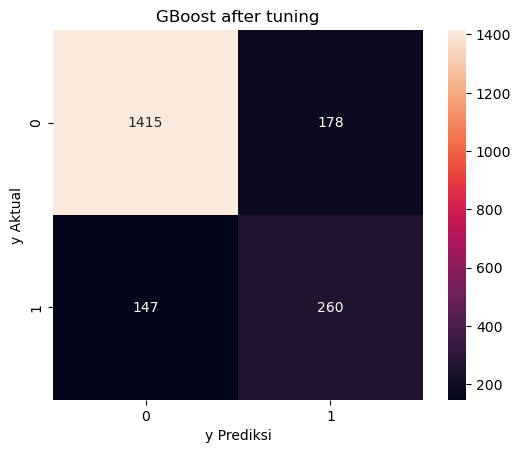

In [38]:
sns.heatmap(confusion_matrix(y_test, y_pred_after), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GBoost after tuning');

📌 Arti False Positive (FP) dan False Negative (FN)
- False Positive (178): Model memprediksi churn, padahal tidak churn 
    +  Bank salah mengira customer akan churn, padahal tetap setia.

- False Negative (147): Model memprediksi tidak churn, padahal churn
    + Bank gagal mendeteksi customer yang akan churn dan tidak sempat melakukan tindakan pencegahan.

💸 Estimasi Kerugian Finansial
Asumsikan:
- Kerugian 1 FN = Rp 5 juta (kehilangan satu customer valuable)
- Biaya 1 FP = Rp 500 ribu (insentif promosi, biaya operasional)

Total FN = 147
Total FP = 178

Insight: 
- Total_FP_Loss = 178 × 500.000 = Rp. 89.000.000
- Total_FN_Loss = 147 × 5.000.000 = Rp. 735.000.000

- Total_Kerugian = Total_FP_Loss + Total_FN_Loss
                = 89.000.000 + 735.000.000
                = Rp. 824.000.000

- Kerugian terbesar datang dari False Negative dengan jumlah Rp 735 juta.


## **11. Save dan Load Model**

In [28]:
import joblib

In [29]:
# Simpan
joblib.dump(best_modelSMOTE, 'GBoostSMOTE_model.joblib')

# Load
model_finalSMOTE= joblib.load('GBoostSMOTE_model.joblib')

## **12. Interpretasi Model**

### SHAP

In [30]:
model_finalSMOTE

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('resampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('modeling',
                 GradientBoostingClassifier(learning_rate=0.11, max_depth=6,
                                            max_features=2, n_estimators=50,
                                            random_state=42))])

In [31]:
import shap

In [32]:
# ambil model dan data dari pipeline
my_model = model_finalSMOTE[-1]
my_data = model_finalSMOTE[0].transform(X_train)


In [33]:
# define explainer
explainer_shap = shap.TreeExplainer(
    model= my_model,
    data= my_data,
    # feature_dependence= 'independent',
    # model_output= 'probability'
)

# hitung shap value untuk tiap baris di data train
shap_values = explainer_shap.shap_values(my_data)

 97%|=================== | 7794/8000 [00:20<00:00]       

In [36]:
# ambil nama feature
feat_scale = model_finalSMOTE['preprocessing'].transformers_[0][2]
feat_onehot = list(model_finalSMOTE['preprocessing'].transformers_[1][1].get_feature_names_out())
feat_remainder = list(X.columns[model_finalSMOTE['preprocessing'].transformers_[2][2]])

feat = feat_scale + feat_onehot + feat_remainder
feat

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard',
 'IsActiveMember']

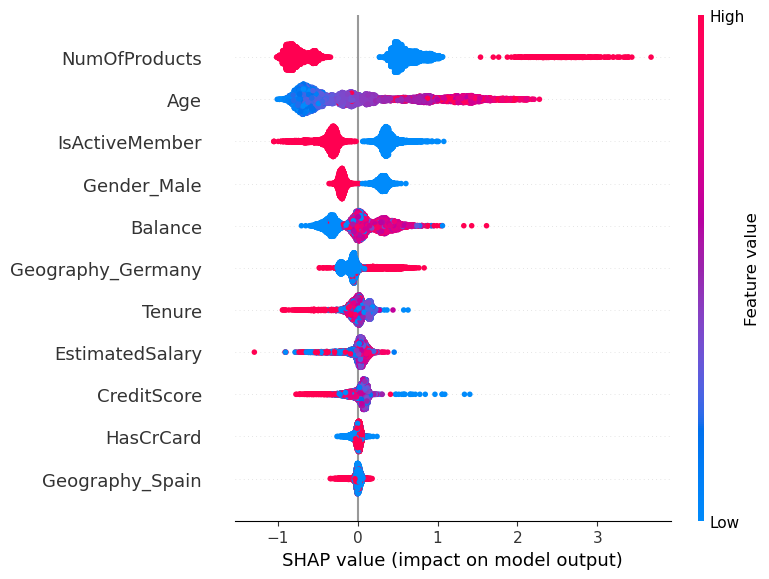

In [37]:
# tampilkan dalam bentuk plot                                 
shap.summary_plot(shap_values, my_data, feature_names=feat)

- Sumbu X: Nilai SHAP (dampak terhadap output model: prediksi churn).
    + Nilai SHAP > 0 → Mendorong prediksi ke kelas churn (1)
    + Nilai SHAP < 0 → Mendorong prediksi ke kelas tidak churn (0)
- Warna: Nilai fitur (merah = tinggi, biru = rendah)

#### Interpretasi Hasil SHAP
- `NumOfProducts`: nilai rendah (biru) mendorong ke Churn
    + Customer bank dengan prodduk sedikit lebih rentan unutk Churn

- `Age` : nilai tinggi (merah) mendorong ke Churn
    + Customer bank dengan usia yang lebih tua lebih rentan untuk Churn

- `IsActiveMember` : nilai rendah (biru) mendorong ke Churn
    + Customer bank yang tidak aktif lebih rentan untuk Churn sedangkan customer bank yang aktif lebih loyal (not Churn)

- `Gender_Male` : nilai rendah (biru) mendorong ke Churn
    + Customer bank Perempuan lebih rentan untuk Churn dibandingkan customer bank laki-laki (merah)

- `Balance` : Terdapat variasi besar di nilai 0 
    + Tidak semua customer dengan saldo besar Churn

- `Georaphy_Germany`: nilai tinggi (merah) mendorong ke Churn
    = Customer dari Germany cendrung diprediksi untuk Churn


#### Kesimpulan SHAP

Model menunjukan bahwa fitur `NumOfProducts`, `Age`, dan `IsActiveMember` merupakan fitur yang paling mendukung prediksi Churn/NotChurn seorang customer bank.

### Feature Importance

In [47]:
X_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1344,460,Germany,Female,40,6,119507.58,2,1,0,91560.63
8167,713,Germany,Female,24,7,147687.24,1,1,1,121592.50
4747,663,Spain,Male,64,6,0.00,2,0,1,15876.52
5004,502,Germany,Female,57,3,101465.31,1,1,0,43568.31
3124,760,France,Male,39,6,178585.46,1,1,0,67131.30


In [38]:
model_finalSMOTE

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('resampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('modeling',
                 GradientBoostingClassifier(learning_rate=0.11, max_depth=6,
                                            max_features=2, n_estimators=50,
                                            random_state=42))])

In [39]:
best_model.named_steps['modeling'].feature_importances_

array([0.02209894, 0.31890992, 0.05977664, 0.1005565 , 0.26292154,
       0.02932501, 0.05668509, 0.01520631, 0.04090785, 0.01583547,
       0.07777674])

In [40]:
transformer.transformers_

[('scaling',
  RobustScaler(),
  ['CreditScore',
   'Age',
   'Tenure',
   'Balance',
   'NumOfProducts',
   'EstimatedSalary']),
 ('onehot', OneHotEncoder(drop='first'), ['Geography', 'Gender']),
 ('remainder',
  FunctionTransformer(accept_sparse=True, check_inverse=False,
                      feature_names_out='one-to-one'),
  [7, 8])]

In [41]:
scaling_cols = list(transformer.transformers_[0][1].get_feature_names_out())
onehot_cols = list(transformer.transformers_[1][1].get_feature_names_out())
remainder_cols = list(transformer.transformers_[2][1].get_feature_names_out())

In [74]:
scaling_cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [42]:
fimportance = pd.DataFrame()
fimportance['Feature'] = scaling_cols + onehot_cols + remainder_cols
fimportance['Importance'] = best_model.named_steps['modeling'].feature_importances_
fimportance = fimportance.sort_values(by='Importance', ascending= False)
fimportance = fimportance.reset_index(drop= True)
fimportance

,Feature,Importance
0,Age,0.318910
1,NumOfProducts,0.262922
2,Balance,0.100557
3,IsActiveMember,0.077777
4,Tenure,0.059777
5,Geography_Germany,0.056685
6,Gender_Male,0.040908
7,EstimatedSalary,0.029325
8,CreditScore,0.022099
9,HasCrCard,0.015835


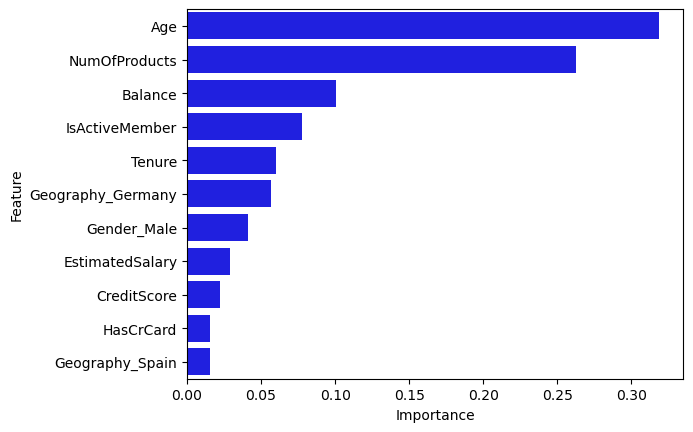

In [43]:
sns.barplot(data=fimportance, y='Feature', x='Importance', color='b');

#### 📊 Interpretasi Setiap Fitur
- `Age` : (~32%)
    + Faktor paling berpengaruh dalam model.
    + Semakin tua usia nasabah, semakin besar kemungkinannya untuk churn (juga terlihat dari SHAP).
    + 🔍 Insight bisnis: Fokus retention ke nasabah usia lanjut, bisa dengan penawaran khusus pensiun atau program loyalitas.

- `NumOfProducts` : (~26%)
    + Jumlah produk yang dimiliki sangat memengaruhi churn.
    + Nasabah dengan lebih banyak produk lebih loyal.
    + 🔍 Insight bisnis: Dorong cross-selling produk (misalnya tabungan + kartu kredit) untuk mengurangi churn.

- `Balance` : (~10%)
    + Nasabah dengan saldo tertentu memiliki kecenderungan churn lebih besar.
    + 🔍 Insight bisnis: Perlu investigasi lebih lanjut: apakah nasabah dengan saldo besar merasa tidak puas?

- `IsActiveMember` : (~8%)
    + Keaktifan nasabah berkontribusi terhadap loyalitas.
    + 🔍 Insight bisnis: Perlu dorong interaksi rutin seperti penggunaan mobile banking atau layanan tambahan.

- `Tenure` & `Geography_Germany` : (~6% masing-masing)
    + Lamanya menjadi nasabah & lokasi juga sedikit memengaruhi churn.
    + 🔍 Insight bisnis: Wilayah seperti Jerman bisa memiliki churn tinggi — periksa kompetitor lokal.

-  `Gender_Male`, `EstimatedSalary`, `CreditScore`, `HasCrCard`, `Geography_Spain`
    + Memiliki pengaruh rendah terhadap keputusan model (masing-masing < 5%).
    + 🔍 Insight bisnis: Mungkin bisa dikesampingkan untuk program prioritas, atau hanya digunakan sebagai fitur tambahan.



#### Kesimpulan Feature Importance

Feature importance menunjukan bahwa `Age`, `NumOfProducts`, `IsActiveMember` merupakan fitur yang penting dalam memprediksi customer Churn/Not Churn

**Perbedaan antara SHAP dan Feature Importances**
- SHAP memberikan informasi mengenai bagaimana secara positif atau negatif suatu fitur mempengaruhi prediksi Churn 
- Feature Importance hanya memberikan informasi mengenai seberapa penting suatu fitur secara keseluruh dalam prediksi Churn

## **13. Kesimpulan dan Rekomendasi**

**1. Performa Model Machine Learning**

Model machine learning yang telah dibuat sudah dapat memprediksi Churn/Not Churn customer bank. Model yang dibuat merupakan Model Gradient Boosting Classifier dengan SMOTE untuk resamplingnya. Performa model ML yang dibuat mencapai F1 score sebesar 62% setelah dilakukan hyperparameter tuning. Akurasi model secara keseluruhan tetap stabil di 84%

**2. Dampak Finansial dari Kesalahan Prediksi (Setelah Tuning)**

Sebelum menggunakan model ML, dapat diasumsikan bahwa tidak ada prediksi churn sama sekali yang berati semua customer bank yang berpotensi untuk churn tidak bisa diidentifikasi sebelumnya

Tanpa model:
- Semua nasabah yang churn (label = 1) akan False Negative (FN).
- Tidak ada False Positive (FP) karena tidak ada tindakan retensi.
    
Dari data:
- Jumlah nasabah churn (support label 1) = 407
    
Maka:
- FN = 407
- FP = 0
    
- Hitung kerugian:
    - FN Loss = 407 × Rp 5.000.000 = Rp 2.035.000.000
    - FP Loss = 0 × Rp 500.000 = Rp 0
    - Total kerugian = **Rp 2.035.000.000**
    
Setelah Tuning Model:
- Total kerugian = **Rp 824.000.000**
- Terdapat **efisiensi biaya** : : Rp 2.035.000.000 – Rp 824.000.000 = **Rp 1.211.000.000**

**3. Rekomendasi**

Secara umum perlu dilakukan optimalisasi strategi retensi untuk mencegah customer yang terprediksi Churn meninggalkan bank:
- Membuat *early warning system* berbasis output model untuk mendeteksi customer bank dengan risiko churn tinggi
- Segmentasi customer terprediksi churn berdasarkan fitur penting `Age`, `NumOfProducts`, `IsActiveMember`
- Melakukan cross-selling produk untuk meningkatkan loyalitas customer bank
- Melakukan aktivasi customer bank yang pasif lewat kampanya dan layanan bernilai tambah
